In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from narrative import nar181026_heat_confidence_genes
from narrative import nar181205_networks

In [6]:
save_images = True

In [7]:
outfolder = '191031_robustness_against_annotation_filtering'

In [8]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

all_de_all = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['de_unit']=='both') &
    (all_de['younger']==4)
]


all_de_orp = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['younger']==4) &   
    (all_de['de_unit']=='both') &
    (all_de['gene_ncbi'].isin(ref_genes))

]

In [10]:
from scipy.stats import spearmanr

In [11]:
from natsort import natsorted

In [12]:
conditions = natsorted(all_de['condition'].unique())

In [13]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [14]:
def get_out(de_set):
    
    out = pd.DataFrame(index=conditions, columns=[
        'corr', 'pval'
    ]).rename_axis('condition')
    
    for condition in conditions:
        d = de_set[
            (de_set['de_unit']=='both') & (de_set['condition']==condition)
        ]

        d = d[['gene_ncbi', 'o_over_y', 'padj']].dropna()
        d = pd.merge(d, pr)

        r, p = spearmanr(d['log_length'], d['o_over_y'])
        d = d.set_index('gene_ncbi')

        out.loc[condition, 'corr'] = r
        out.loc[condition, 'pval'] = p
        
    out = out.reset_index()
    return out

In [15]:
orp = get_out(all_de_orp)
filterless = get_out(all_de_all)

In [16]:
orp = orp.dropna()

In [17]:
filterless = filterless.dropna()

In [18]:
g = pd.merge(orp, filterless, on=['condition'], suffixes=('_orp', '_filterless'))

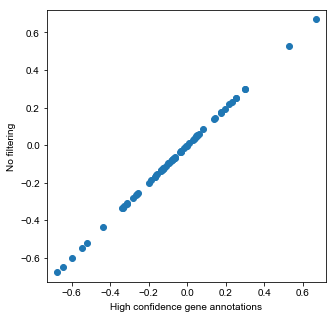

In [19]:
plt.figure(figsize=(5, 5))
plt.scatter(g['corr_orp'], g['corr_filterless'])
plt.xlabel('High confidence gene annotations')
plt.ylabel('No filtering')
mi = g[['corr_orp', 'corr_filterless']].min(1).min()-0.05
ma = g[['corr_orp', 'corr_filterless']].max(1).max()+0.05
plt.xlim([mi, ma])
plt.ylim([mi, ma])



if save_images:
    export.export_image('{}/correlation_across_filtering.pdf'.format(outfolder))

In [20]:
g.head()

,condition,corr_orp,pval_orp,corr_filterless,pval_filterless
0,Adrenal_0_4_9,-0.0036287,0.729003,-0.00360318,0.730735
1,Adrenal_0_4_12,-0.0832552,2.09174e-16,-0.0832371,2.07146e-16
2,Adrenal_0_4_18,0.0600566,1.6534e-09,0.0602259,1.46867e-09
3,Adrenal_0_4_24,-0.162002,1.07144e-58,-0.161647,1.7451e-58
4,BAT_0_4_9,-0.0153825,0.106979,-0.0153949,0.106506
